# Precision-Recall

## Background

I'm familiarizing myself with basic ML concept of Precision-Recall curve to build intuition around it.

My source: https://scikit-learn.org/dev/auto_examples/model_selection/plot_precision_recall.html

## First, we'll load a small toy dataset

Following the SciKit doc, we'll use Iris (flower, not part of an eye, or godess).

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics._ranking import precision_recall_curve
import pandas
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import PrecisionRecallDisplay

random_state = np.random.RandomState(3)

X, y = load_iris(return_X_y=True)

## Mess it up

The dataset has 150 records, 4 floating-point flower properties (like length) for X, and specific flower species label for Y (0, 1, 2).
There are 310 Iris species, but this small dataset has only 3.
So, it's kinda multilabel.
We don't need that, for precision-recall we need something binary.
So we trim both X and Y to only keep records for `Y=0` aka False and `1` aka True.

In [2]:
X, y = X[y<2], y[y<2]
pandas.DataFrame(X)

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
95,5.7,3.0,4.2,1.2
96,5.7,2.9,4.2,1.3
97,6.2,2.9,4.3,1.3
98,5.1,2.5,3.0,1.1


In [3]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

It's good that it's binary now, but it's too easy. If we train a model on this data now, it will have 100% accuracy, so precision and recall will look stupied.
So, we add noisy features, a whole lot, 100 times more noise than signal.
That will make model to sweat.

In [4]:
X = np.concatenate([X, random_state.randn(X.shape[0], 100 * X.shape[1])], axis=1)

pandas.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,394,395,396,397,398,399,400,401,402,403
0,5.1,3.5,1.4,0.2,1.788628,0.436510,0.096497,-1.863493,-0.277388,-0.354759,...,-0.041844,-0.272736,-2.676521,-0.430101,0.084964,1.097779,2.046333,0.666988,0.079092,-0.964763
1,4.9,3.0,1.4,0.2,0.089053,0.778897,1.264645,-0.880511,0.236406,0.815604,...,-0.695176,0.350235,0.877156,-1.154259,0.167770,0.247067,-0.334747,-0.487161,-1.854910,1.148821
2,4.7,3.2,1.3,0.2,-0.932924,-1.240371,0.657913,-1.832275,0.963271,0.434219,...,1.220892,-2.011595,-1.504712,-0.149936,0.027270,-1.604372,-0.674309,-0.455614,-0.497364,-0.518032
3,4.6,3.1,1.5,0.2,-0.140283,0.830035,0.686235,0.538731,0.221271,-0.770385,...,-0.290146,1.390606,-1.455962,0.569578,0.006109,0.859871,-0.444911,0.753343,-0.467831,0.663535
4,5.0,3.6,1.4,0.2,-1.922484,0.528894,0.782406,-1.553416,0.890992,-1.091646,...,1.027371,-1.060412,0.745221,-1.398008,0.078579,-1.648937,-0.172256,-0.816176,-1.003245,0.214830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,-1.048244,0.062068,-0.304341,-0.516236,0.432118,0.675260,...,1.365158,0.914614,0.020456,-0.314531,1.468110,1.703369,0.409053,-0.293020,-0.038827,-0.759583
96,5.7,2.9,4.2,1.3,1.586293,-0.490875,-1.612975,0.097659,-0.170520,1.269662,...,-1.006722,1.040696,-1.780113,0.576967,0.222845,-0.030648,1.560297,1.289232,0.005855,-1.530362
97,6.2,2.9,4.3,1.3,0.845536,-1.045338,-1.111983,-0.156758,0.316664,0.104065,...,0.167184,0.398998,0.104368,1.282921,-1.973232,1.331549,1.144706,0.378739,0.497428,0.880610
98,5.1,2.5,3.0,1.1,0.252259,1.805827,-0.505050,0.088796,-0.059348,-1.280433,...,-1.077416,0.696924,-0.582393,-1.444338,-1.175554,0.287162,-1.674579,1.712218,-0.191547,-0.217705


## Split to train and test data

Because we're such great data scientists, we can't even think about testing the model on training data even for educational purposes.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)

In [6]:
classifier = make_pipeline(StandardScaler(), LinearSVC(random_state=random_state))
classifier.fit(X_train, y_train);

## Boom, we've got a binary classifier model

We trained it to predict the likelyhood of smoking pile of garbage being Iris flower of species number 1.
For whatever `4 + 400` floats we throw in, the model returns a *score* of how likely the label is 1.
Let's take a look at the test output.

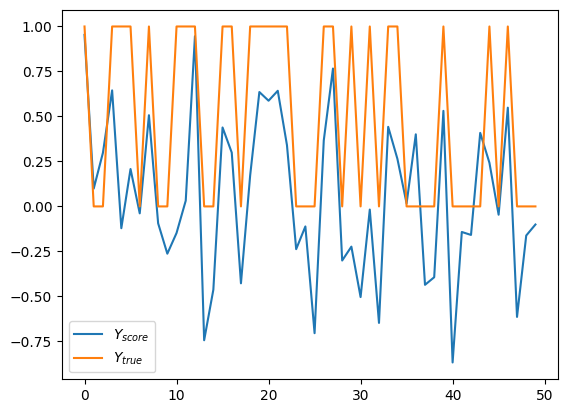

In [7]:
y_score = classifier.decision_function(X_test)
pandas.DataFrame.from_dict({
    '$Y_{score}$': y_score,
    '$Y_{true}$': y_test,
}).plot();

Note how $Y_{score}$ values are small signed floating point numbers unlike label, which are either 0 or 1.
That's because the score doesn't directly map to the label.
Very loosely, it's a likelyhood of input having labeled as 1, but not in statistical terms.
Let's say, there is a correlation.
Ok, that might be not the best way to present this data.
How about we plot only scores, and paint it red for label 1 and blue for label 0.

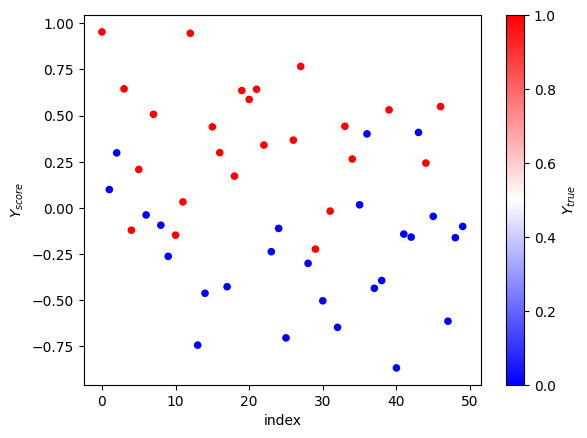

In [8]:
pandas.DataFrame.from_dict({
    '$Y_{score}$': y_score,
    '$Y_{true}$': y_test,
}).reset_index().plot(
    kind='scatter',
    x='index',
    y='$Y_{score}$',
    c='$Y_{true}$',
    colormap='bwr',
);

That easier on the eye.
We can see that dots at the top are red, dots at the bottom are blue, and in the middle there's a mix.
To actually tell, if the score predicts the label to be 1, we need to have a threshold.
With the threshold, we'll be able to say, okay, everything above this magical number has label 1.

## Let's build some curves

Scikit learn provides handy implementation for drawing the P/R curve, let's take a look, so we know what good looks like.

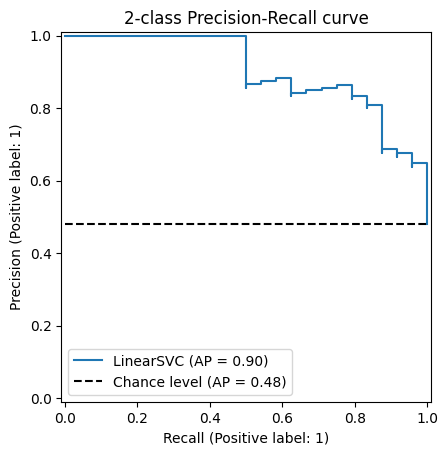

In [9]:
display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="LinearSVC", plot_chance_level=True
).ax_.set_title("2-class Precision-Recall curve")

Beautiful, it's like a staircase that mostly goes down, except half of the time it goes up. Definitely tells me a lot about the quality of this model (it doesn't).

## Let's get under the hood

First, we'll sort the "true" labels (y_test) and the predicted scores (y_score) together by score.

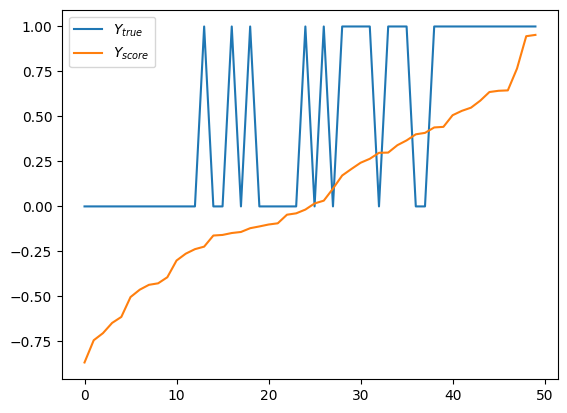

In [10]:
score_indices = np.argsort(y_score)
sy_score = y_score[score_indices]
sy_test = y_test[score_indices]
pandas.DataFrame.from_dict({'$Y_{true}$': sy_test, '$Y_{score}$': sy_score}).plot();

Looks good, very organized. Y_score grows monotonically through its range, while y_true jumps up and down like crazy. But if we squeeze hard enough, we'll see that we have more 1's on the right side.
Actually, let's do that color trick again.

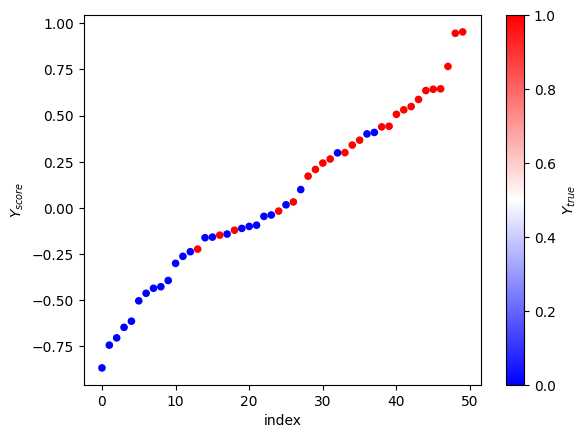

In [11]:
(pandas.DataFrame.from_dict({'$Y_{score}$': sy_score, '$Y_{true}$': sy_test})
       .reset_index()
       .plot(kind='scatter', x='index', y='$Y_{score}$', c='$Y_{true}$', colormap='bwr'));

Nice, good job. We can eye-ball that the right threshold for y_score is around 0, maybe 0.1. The P/R curve will help us pick the right number for we are the professionals and never eye-ball shit.

## Precision, recall, and threshold

Let's use this handy function from scikit to compute precision, recall, and threshold.
It takes `y_test` as `y_true` - the true test labels from the dataset, and `y_score` - the predicted score.
It returns three lists of floats of the same length as the score and true labels.

In mathematical notation:

- $N$ - number of labels, same as number of scores.
- $Y$ - `y_true` - the true (test) label for the record.
- $\hat{Y}$ - `y_score` - the predicted score.
- $P=\sum_{i=0}^{N}{Y_i}$ - total number of positive test labels.

It sorts $(Y, \hat{Y})$ pairs by $\hat{Y}$.
And then iterates over them while running cumulative sums and doing simple math.
At each iteration of the loop it calculates precision and recall at this score threshold:

- $S_i=\hat{Y_{i}}$ - append the current score to the list of *thresholds*.
- $T_i=\sum_{k=0}^{i}{(Y_k=1)}$ - cumulative count of *true positives* so far.
- $P_i = \frac{T_i}{i}$ - calculate precision at `i` as the number of true positives divided by the number of records already seen.
- $R_i = \frac{T_i}{P}$ - calculate recall at `i` as the number of true positives divided by total number of true labels.

## English, please

We want to find a *threshold* such that any `y_score` above it means the label is 1.
We saw that the prediction is not always accurate and the data is noisy, so we need to have a number.
The number will tell us how confident we are in the label prediction.
The name for it is precision.
When the precision is 1 it means that we never make mistake by predicting label 1 to something that is label 0.
It says nothing about the other kind of mistake, though.
Predicting label 0 to what is actually label 1 is okay, and doesn't hurt the precision.
Maybe *conservative* is a good word, at least *asymmetrical*.
Of course, everybody in this data science field undestands it, and never bothers to clarify this detail, just calling it a precision.

Great, back to the threshold.
If the treshold is set below the minimum observed score, it means that everything is label 1, and nothing is label 0.
The recall for such threshold would be 100%, it finds all true positives.
The precision would point to whatever the proportion of labels is in the dataset.
It's not zero, because it's sometimes right, it's not 100% because it sometimes wrong.

On the other hand, if the score threshold is set above the maximum observed value, everything gets label 0.
Super conservative.
The precision of such system is 100%, because it never make a mistake of saying that the label is 1 for something that is 0.
Those who do nothing, never make mistakes.
The recall is zero, though, as nothing is ever found.

## Computation details

We want is to calculate precision and recall for every possible score.
But we can't cover all possible numbers.
Luckily, we don't need to.
Because our evaluation dataset is finite, and between the adjacent points, the precision and recall is the same.
So instead of going over all possible numbers, we just need to iterate over all observed scores.

For each score we want to know how many points were below it, and how many of those had the true label of 1.
This asks for some sorting.
The trick is to sort all pairs (of score and true label) by score in a *descending order*.
Then, computing the threshold becomes very easy, it's just the score at every point.

For every threshold (assuming unique score thresholds) we want to find precision and recall.
Being at this threshold means that all the points below are predicted to be labeled 0, and all the points above are predicted as 1.
The precision of such prediction is the number of points above that are actually labeled 1, divided by the total number of points above.
We, professionals, say: number of *true positives* divided by sum of *true positives* an *false positives*.
In other words, we divide the real number of positive values by the number of positive predictions, and that's the precision at this threshold.

We could have stopped here, you know. You want your predictions to be correct 90% of the times, pick the score threshold where your precision is closest to 0.9.

But we're curious, as the real professional data scientists are.
So we need to know more about the data.
We'll calculate the recall.
Recall is a funky term, that shows how many *true positives* we have predicted out all the positive values.
We take the number of *true positives* seen so far, just like for the precision.
But now we divide it by the total number of points with true label 1 in the evaluation dataset.
That's right, the denominator for the recall is constant at each iteration, and the nominator is ever-increasing.
At the beginning of the loop when the score threshold is at the highest, and we haven't observed any true positives, the recall is zero.
At the end, when score threshold is at the lowest score, the recall is the number of *true positives* divided by the total number of points with label 1.

In [12]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_score)
thresholds = np.append(thresholds, float('nan'))
precisions.shape, recalls.shape, thresholds.shape

((51,), (51,), (51,))

## Let's take a look

Okay, that was all good knowledge, thank you very much, but can you show me some examples?
How about we plot these 3 sequences against each other?

First, all three lines on the same chart.

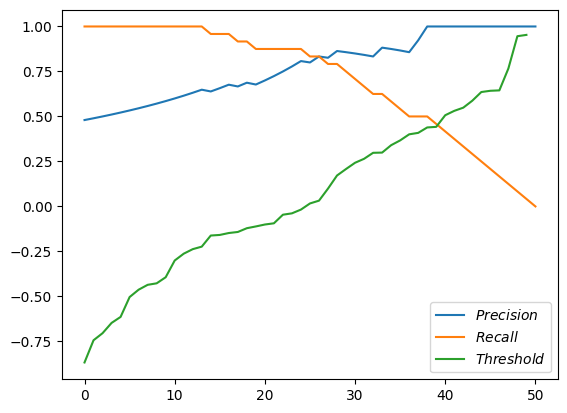

In [13]:
pandas.DataFrame.from_dict({'$Precision$': precisions, '$Recall$': recalls, '$Threshold$': thresholds}).plot();

Magnificient! But not very helpful. We see that the threshold are just sorted scores. We see recall starting at 1.0 and going down to zero. And the precision starts somewhere around 0.5 and goes up (and sometimes down) to 1.0.

How about we put recall as the X axis, and plot precision and thresholds as Y.

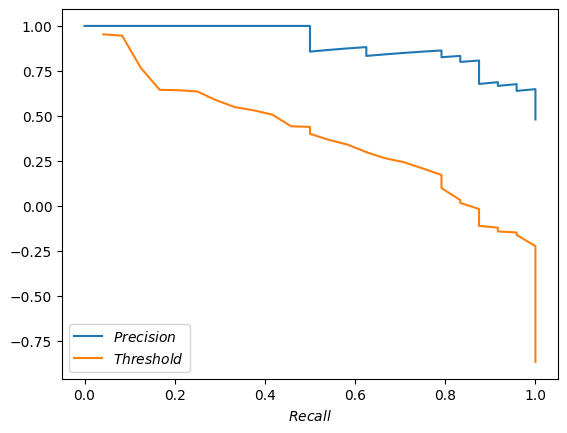

In [14]:
pandas.DataFrame.from_dict({'$Precision$': precisions, '$Recall$': recalls, '$Threshold$': thresholds}).plot(x='$Recall$');

Yeah, that's very close to what scikit plotted for us above. The steps are not as pronounced, but that's fine.

How about we go crazy and plot both precision and recall against the threshold?

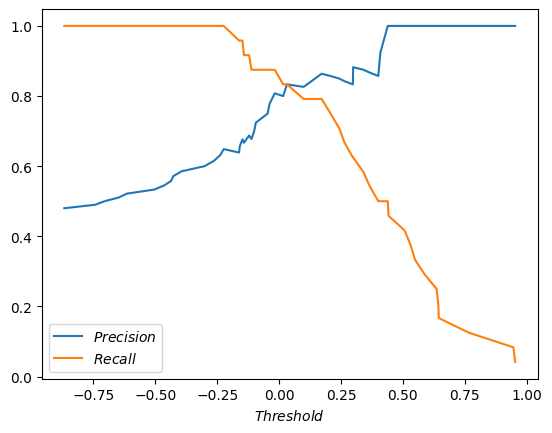

In [15]:
pandas.DataFrame.from_dict({'$Precision$': precisions, '$Recall$': recalls, '$Threshold$': thresholds}).plot(x='$Threshold$');

The lines cross! What a coincedence (it's not). Funny, that the threshold of the cross is about where we (no, you, against my better judgement) eye-balled the sweet spot.
Is there any theoretical significance to this spot? I don't think so. You don't get the biggest bang for your buck by jerking target precision for the system after every evaluation. You want the target precision to be good and stable, and preferrably decided by someone who understands the product, the users, and also that murky statistical part, that precision doesn't take into account *false negatives* - predictions of label 0 when it's actually 1.